## Introduction and Setup

### Binomial Option Pricing Model
The Binomial Option Pricing Model is a discrete-time framework for valuing options. It represents the price evolution of the underlying asset as a tree of possible values over time.

Each node \((i, j)\) in the tree corresponds to:
1. A specific time step \(i\).
2. A potential price outcome \(S_{i,j}\).

At each node, the option value depends on:
1. The **payoff** at expiration.
2. The discounted expected value of future payoffs.

### Why Choosing Parameters is Important
Different variations of the binomial model affect:
1. The up (\(u\)) and down (\(d\)) movement factors.
2. The probability of an upward movement (\(q\)).
3. The convergence speed of the computed option price to the theoretical value (e.g., Black-Scholes).

This notebook explores four popular parameterization methods:
1. **Cox, Ross, and Rubinstein (CRR):** Uses equal jump sizes for up and down movements.
2. **Jarrow and Rudd (JR):** Adjusts for a risk-neutral measure while maintaining equal probabilities.
3. **Equal Probabilities (EQP):** Modifies up and down jumps for a logarithmic asset pricing tree.
4. **Trigeorgis (TRG):** Ensures equal jump sizes under a logarithmic asset pricing tree.

### Goal
We aim to:
1. Implement these parameterization methods.
2. Compare their convergence characteristics against the Black-Scholes formula for pricing European Call options.

In [1]:
import numpy as np  # For numerical operations

# Initialize parameters
S0 = 100       # Initial stock price
K = 110        # Strike price
T = 0.5        # Time to maturity (in years)
r = 0.06       # Annual risk-free rate
N = 100        # Number of time steps
sigma = 0.3    # Annualized stock price volatility
opttype = 'C'  # Option type: 'C' for Call, 'P' for Put

## Cox, Ross, and Rubinstein (CRR) Method

### Overview
The CRR method is a classic parameterization for the binomial model. It assumes:
1. **Equal Jump Sizes:** The factors for up and down movements are inverses:
   \[
   u = e^{\sigma \sqrt{\Delta t}}, \quad d = \frac{1}{u}
   \]
2. **Risk-Neutral Probabilities:** The probability of an upward movement is:
   \[
   q = \frac{e^{r \Delta t} - d}{u - d}
   \]
3. **Option Pricing:** The option price is calculated through backward induction.

### Steps
1. Compute \(u\), \(d\), and \(q\).
2. Generate the stock price tree.
3. Calculate the option payoff at maturity.
4. Use backward induction to compute the option value at earlier nodes.

In [2]:
def CRR_method(K, T, S0, r, N, sigma, opttype='C'):
    # Precompute constants
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    q = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    disc = np.exp(-r * dt)  # Discount factor

    # Initialize asset prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * d**N  # Lowest price at maturity
    for j in range(1, N + 1):
        S[j] = S[j - 1] * u / d

    # Initialize option values at maturity
    C = np.zeros(N + 1)
    for j in range(N + 1):
        if opttype == 'C':
            C[j] = max(0, S[j] - K)  # Call option payoff
        else:
            C[j] = max(0, K - S[j])  # Put option payoff

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            C[j] = disc * (q * C[j + 1] + (1 - q) * C[j])
    
    return C[0]

# Example usage
CRR_method(K, T, S0, r, N, sigma, opttype='C')

5.77342630682585

## Jarrow and Rudd (JR) Method

### Overview
The JR method modifies the CRR approach by introducing a drift adjustment (\(\nu\)) for the risk-neutral measure:
\[
\nu = r - \frac{\sigma^2}{2}
\]
Under the JR method:
1. **Up and Down Factors:** These incorporate the drift:
   \[
   u = e^{\nu \Delta t + \sigma \sqrt{\Delta t}}, \quad d = e^{\nu \Delta t - \sigma \sqrt{\Delta t}}
   \]
2. **Equal Probabilities:** The upward and downward probabilities are set to:
   \[
   q = 0.5
   \]

### Steps
1. Compute \(u\), \(d\), and \(q\).
2. Generate the stock price tree and option payoff at maturity.
3. Use backward induction to calculate the option price.

In [3]:
def JR_method(K, T, S0, r, N, sigma, opttype='C'):
    # Precompute constants
    dt = T / N
    nu = r - 0.5 * sigma**2  # Drift adjustment
    u = np.exp(nu * dt + sigma * np.sqrt(dt))  # Up factor
    d = np.exp(nu * dt - sigma * np.sqrt(dt))  # Down factor
    q = 0.5  # Equal probabilities
    disc = np.exp(-r * dt)  # Discount factor

    # Initialize asset prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * d**N
    for j in range(1, N + 1):
        S[j] = S[j - 1] * u / d

    # Initialize option values at maturity
    C = np.zeros(N + 1)
    for j in range(N + 1):
        if opttype == 'C':
            C[j] = max(0, S[j] - K)
        else:
            C[j] = max(0, K - S[j])

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            C[j] = disc * (q * C[j + 1] + (1 - q) * C[j])
    
    return C[0]

# Example usage
JR_method(K, T, S0, r, N, sigma, opttype='C')

5.754089414567556

## Equal Probabilities (EQP) Method

### Overview
The EQP method focuses on equal risk-neutral probabilities (\(q = 0.5\)) while adjusting the up and down factors (\(dx_u, dx_d\)) for a logarithmic asset pricing tree. It incorporates both drift and volatility into these factors:
\[
dx_u = 0.5 \nu \Delta t + 0.5 \sqrt{4 \sigma^2 \Delta t - 3 \nu^2 \Delta t^2}
\]
\[
dx_d = 1.5 \nu \Delta t - 0.5 \sqrt{4 \sigma^2 \Delta t - 3 \nu^2 \Delta t^2}
\]

Where:
- \(\nu = r - \frac{\sigma^2}{2}\): Drift adjustment.
- \(dx_u\) and \(dx_d\) define the multiplicative factors for up and down movements in the logarithmic price space.

### Key Characteristics
1. **Stock Prices:** Adjusted for logarithmic movements:
   \[
   S_{i,j} = S_0 \exp(j \cdot dx_u + (i-j) \cdot dx_d)
   \]
2. **Option Pricing:** Backward induction is performed with equal probabilities:
   \[
   q = p_u = 0.5, \quad p_d = 1 - q
   \]

In [4]:
def EQP_method(K, T, S0, r, N, sigma, opttype='C'):
    # Precompute constants
    dt = T / N
    nu = r - 0.5 * sigma**2
    dxu = 0.5 * nu * dt + 0.5 * np.sqrt(4 * sigma**2 * dt - 3 * nu**2 * dt**2)
    dxd = 1.5 * nu * dt - 0.5 * np.sqrt(4 * sigma**2 * dt - 3 * nu**2 * dt**2)
    pu = 0.5  # Equal probabilities
    pd = 1 - pu
    disc = np.exp(-r * dt)

    # Initialize asset prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * np.exp(N * dxd)
    for j in range(1, N + 1):
        S[j] = S[j - 1] * np.exp(dxu - dxd)

    # Initialize option values at maturity
    C = np.zeros(N + 1)
    for j in range(N + 1):
        if opttype == 'C':
            C[j] = max(0, S[j] - K)
        else:
            C[j] = max(0, K - S[j])

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            C[j] = disc * (pu * C[j + 1] + pd * C[j])
    
    return C[0]

# Example usage
EQP_method(K, T, S0, r, N, sigma, opttype='C')

5.7365844788666545

## Trigeorgis (TRG) Method

### Overview
The TRG method ensures **equal jump sizes** under a logarithmic asset pricing tree while accounting for drift (\(\nu\)) and volatility (\(\sigma\)):
\[
dx_u = \sqrt{\sigma^2 \Delta t + \nu^2 \Delta t^2}, \quad dx_d = -dx_u
\]

The probabilities for upward and downward movements are:
\[
p_u = 0.5 + 0.5 \frac{\nu \Delta t}{dx_u}, \quad p_d = 1 - p_u
\]

### Key Characteristics
1. **Stock Prices:** Adjusted for logarithmic jumps:
   \[
   S_{i,j} = S_0 \exp(j \cdot dx_u + (i-j) \cdot dx_d)
   \]
2. **Option Pricing:** Similar to other methods, backward induction is applied using the computed probabilities \(p_u\) and \(p_d\).

In [5]:
def TRG_method(K, T, S0, r, N, sigma, opttype='C'):
    # Precompute constants
    dt = T / N
    nu = r - 0.5 * sigma**2
    dxu = np.sqrt(sigma**2 * dt + nu**2 * dt**2)
    dxd = -dxu
    pu = 0.5 + 0.5 * nu * dt / dxu
    pd = 1 - pu
    disc = np.exp(-r * dt)

    # Initialize asset prices at maturity
    S = np.zeros(N + 1)
    S[0] = S0 * np.exp(N * dxd)
    for j in range(1, N + 1):
        S[j] = S[j - 1] * np.exp(dxu - dxd)

    # Initialize option values at maturity
    C = np.zeros(N + 1)
    for j in range(N + 1):
        if opttype == 'C':
            C[j] = max(0, S[j] - K)
        else:
            C[j] = max(0, K - S[j])

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            C[j] = disc * (pu * C[j + 1] + pd * C[j])
    
    return C[0]

# Example usage
TRG_method(K, T, S0, r, N, sigma, opttype='C')

5.773359020180677

## Comparison of Methods

### Objective
Evaluate the convergence of each parameterization method as the number of time steps (\(N\)) increases. The benchmark is the **Black-Scholes formula** for pricing European Call options.

### Methodology
1. Compute the option price for each method (\(CRR\), \(JR\), \(EQP\), \(TRG\)) over a range of \(N\).
2. Compare against the theoretical Black-Scholes price.

### Visualization
- Plot the computed prices for each method.
- Highlight how quickly each method converges to the Black-Scholes price.

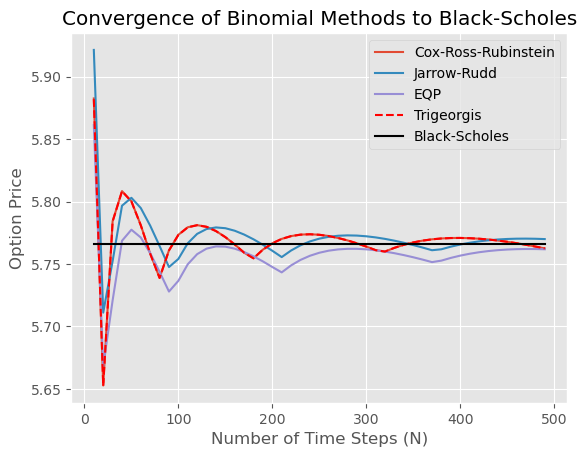

In [13]:
from py_vollib.black_scholes import black_scholes as bs
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Compute option prices for different time steps
CRR, JR, EQP, TRG = [], [], [], []
periods = range(10, 500, 10)

for N in periods:
    CRR.append(CRR_method(K, T, S0, r, N, sigma, opttype='C'))
    JR.append(JR_method(K, T, S0, r, N, sigma, opttype='C'))
    EQP.append(EQP_method(K, T, S0, r, N, sigma, opttype='C'))
    TRG.append(TRG_method(K, T, S0, r, N, sigma, opttype='C'))

# Black-Scholes price
BS = [bs('c', S0, K, T, r, sigma) for _ in periods]

# Plot results
plt.plot(periods, CRR, label='Cox-Ross-Rubinstein')
plt.plot(periods, JR, label='Jarrow-Rudd')
plt.plot(periods, EQP, label='EQP')
plt.plot(periods, TRG, label='Trigeorgis', linestyle='--', color='r')
plt.plot(periods, BS, label='Black-Scholes', linestyle='-', color='k')
plt.legend(loc='upper right')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Methods to Black-Scholes')
plt.show()